# ABM para Investigação de Dinâmicas Populacionais Urbanas

O objetivo de um ABM é buscar uma transição de fase definida por um comportamento emergente no espaço dos parâmetros do modelo.

O modelo original tinha 2 tipos de agente
- **Povo de Rua** (a) com um parâmetro de threshold que define uma regra de mudança;
- **Domicilios** (b) com um parâmetro de threshold que define uma regra de mudança;

Esses agentes ocupavam uma grade retangular MxN que continha apenas um atributo: a contagem de agentes do tipo (b) em cada célula. Para os agentes (a) a regra threshold forçava uma mudança (aleatória na grade) quando o número de agentes em sua célula do tipo (b) caia abaixo de um certo valor. Já os agentes do tipo (b) tinham uma regra de threshold que forçava uma mudança (aleatória na grade) quando o número de agente em sua célula crescia demais.

Os threshold eram definidos através de variáveis aleatórias, amostrada na criação de cada instância de um agente. O parâmetro deste modelo era justamente a relação entre Densidade de Agentes (tamanho da grade por número de instâncias de agentes), e os parâmetros das distribuições de threshold.

Falta um atributo de VALOR que seja composto por diversos outros atributos da grade;
Falta um agente de Segurança;
Falta atributos de Infraestrutura;

## FUNÇÃO VALOR
Consegue transformar uma célula da grade em valor para cada um dos agentes.

## AGENTE SEGURANÇA (c)
Tem um threshold sobre o valor(a * SA, b * SB) - se a soma deles cai para baixo de um threshold, ela se muda.
### Alteração do valor(a)
Deve dificultar a presença do agente tipo (a) - reduzindo o valor(a) de uma célular.

## FUNÇÃO INFRAESTUTURA
Uma função que atribui a cada célula um valor de infraestrutura.
### Alocação de Infraestrutura
Inicialmente faremos uma alocação usando ruído de Perlin. A cada etapa, o valor de N regiões (N sendo um parametro do modelo, chamado Orçamento) é incrementado. A função de ranqueamento tem que penalizar (temos?) celulas de alta infrasestrutura existente e beneficiar celulas de alta população.
#### SP Capital
A alocação de recursos é limitada pelos limites geopolíticos da cidade.
### Deterioração da Infraestrutura
A cada etapa da simulação, cada célula tem uma chance de perder N pontos de infraestrutura.

## AGENTE IGREJA (d)
Tem um threshold sobre o valor(a * IA, b * IB) - se a soma deles cai para baixo de um threshold, ela se muda.
### Alteração do valor(a)
A Igreja busca construir um equilibrio da população do agente (a) - ela altera o valor da celula para agentes (a) nos dois sentidos: se o valor está abaixo de um threshold, ela o aumenta, se ele esta acima, ela o reduz.

# Framework de Desenvolvimento

- Começar implantando infraestrutura.
- Adicionar agentes (c) e (d)
 

## Usando MESA

In [2]:
import mesa, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto, norm, lognorm
from perlin_noise import PerlinNoise

In [5]:
def perlin_grid(height, width):
    noise1 = PerlinNoise(octaves=3)
    noise2 = PerlinNoise(octaves=6)
    noise3 = PerlinNoise(octaves=12)
    noise4 = PerlinNoise(octaves=24)

    xpix, ypix = height, width
    pic = []
    for i in range(xpix):
        row = []
        for j in range(ypix):
            noise_val = noise1([i/xpix, j/ypix])
            noise_val += 0.5 * noise2([i/xpix, j/ypix])
            noise_val += 0.25 * noise3([i/xpix, j/ypix])
            noise_val += 0.125 * noise4([i/xpix, j/ypix])

            row.append(noise_val)
        pic.append(row)
    pic_array = np.array(pic)
    pic_array = pic_array - np.min(pic_array)
    pic_array = pic_array/np.max(pic_array)
    return pic_array

def gini_espacial(model, tipo_agente):
    ocup = [
        len([pessoa for pessoa in cell[0] if isinstance(pessoa, tipo_agente)])
        for cell in model.grid.coord_iter()
    ]
    x = sorted(ocup)
    N = model.grid.height * model.grid.width
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

In [6]:
class PopRua(mesa.Agent):
    def __init__(self, unique_id, model, parametros_agente):
        '''
        parametros_agente: tuple com os parametros de cada tipo de agente diferente
        '''
        super().__init__(unique_id, model)
        self.threshold = np.max([0,norm.rvs(parametros_agente[0], parametros_agente[1])])
        self.peso_seg = parametros_agente[2]
        self.viol = 0

    def value_function(self):
        value = self.model.location.param_dict[self.pos[0]][self.pos[1]]['value']
        infra = self.model.location.param_dict[self.pos[0]][self.pos[1]]['infrastructure']
        pop_seg = 0
        for neighbor in self.model.grid.get_neighbors(self.pos, moore = True, include_center = True):
            if isinstance(neighbor, PopSeg):
                pop_seg += 1
        return value + (PESO_INFRA * infra) - (self.peso_seg * pop_seg/9)

    def move(self):
        new_position_x = random.randint(0, self.model.grid.height - 1)
        new_position_y = random.randint(0, self.model.grid.width - 1)
        new_position = (new_position_x, new_position_y)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        if self.value_function() < self.threshold:
            self.viol += 1
        if self.viol >= TX_VIOL_RUA:
            self.viol = 0
            self.move()

class PopCasa(mesa.Agent):
    def __init__(self, unique_id, model, parametros_agente):
        '''
        parametros_agente: tuple com os parametros de cada tipo de agente diferente
        '''
        super().__init__(unique_id, model)
        self.threshold = pareto.rvs(b=parametros_agente[0]) * parametros_agente[1]
        self.peso_rua = parametros_agente[2]
        self.viol = 0

    def value_function(self):
        value = self.model.location.param_dict[self.pos[0]][self.pos[1]]['value']
        infra = self.model.location.param_dict[self.pos[0]][self.pos[1]]['infrastructure']
        pop_rua = 0
        for neighbor in self.model.grid.get_neighbors(self.pos, moore = True, include_center = True):
            if isinstance(neighbor, PopRua):
                pop_rua += 1
        return value - (self.peso_rua * pop_rua/9)

    def move(self):
        new_position_x = random.randint(0, self.model.grid.height - 1)
        new_position_y = random.randint(0, self.model.grid.width - 1)
        new_position = (new_position_x, new_position_y)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        infra = self.model.location.param_dict[self.pos[0]][self.pos[1]]['infrastructure']
        if self.value_function() > self.threshold + (PESO_INFRA * infra):
            self.viol += 1
        if self.viol >= TX_VIOL_CASA:
            self.viol = 0
            self.move()

class PopSeg(mesa.Agent):
    def __init__(self, unique_id, model, parametros_agente):
        '''
        parametros_agente: tuple com os parametros de cada tipo de agente diferente
        '''
        super().__init__(unique_id, model)
        self.peso_dom = parametros_agente[0]
        self.peso_rua = parametros_agente[1]
        self.threshold = parametros_agente[2]

    def move(self):
        new_position_x = random.randint(0, self.model.grid.height - 1)
        new_position_y = random.randint(0, self.model.grid.width - 1)
        new_position = (new_position_x, new_position_y)
        self.model.grid.move_agent(self, new_position)

    def value_function(self):
        pop_rua = 0
        pop_dom = 0
        for neighbor in self.model.grid.get_neighbors(self.pos, moore = True, include_center = True):
            if isinstance(neighbor, PopCasa):
                pop_dom += 1
            elif isinstance(neighbor, PopRua):
                pop_rua += 1
        return self.peso_dom * pop_dom/9 + self.peso_rua * pop_rua/9

    def step(self):
        if self.value_function() < self.threshold:
            self.move()

class PopRel(mesa.Agent):
    def __init__(self, unique_id, model, parametros_agente):
        '''
        parametros_agente: tuple com os parametros de cada tipo de agente diferente
        '''
        super().__init__(unique_id, model)
        self.peso_rua = parametros_agente[0]
        self.threshold = parametros_agente[1]

    def move(self):
        new_position_x = random.randint(0, self.model.grid.height - 1)
        new_position_y = random.randint(0, self.model.grid.width - 1)
        new_position = (new_position_x, new_position_y)
        self.model.grid.move_agent(self, new_position)

    def value_function(self):
        pop_rua = 0
        for neighbor in self.model.grid.get_neighbors(self.pos, moore = True, include_center = True):
            if isinstance(neighbor, PopRua):
                pop_rua += 1
        return self.peso_rua * pop_rua/9

    def step(self):
        if self.value_function() < self.threshold:
            self.move()

class Locacao:
    '''
    '''
    def __init__(self, height, width, model):
        param_dict = dict()
        self.model = model
        
        for i in range(height):
            param_dict[i] = dict()
            for j in range(width):
                param_dict[i][j] = dict()
        self.param_dict = param_dict
        self.initialize_infrastructure(height, width)

    def update_value(self):
        '''
        O valor de uma célula da grade é a média do número de pessoas na vizinhança de Moore da celula.
        '''
        for cell in self.model.grid.coord_iter():
            viz = self.model.grid.get_neighborhood(
                (cell[1], cell[2]), moore=True, include_center=True
            )
            pessoas = []
            for cell_v in viz:
                pessoas.extend(self.model.grid.get_cell_list_contents(cell_v))

            casas = [pessoa for pessoa in pessoas if isinstance(pessoa, PopCasa)]
            poprua = [pessoa for pessoa in pessoas if isinstance(pessoa, PopRua)]
            num_ocup = len(casas) / 9 - len(poprua) / 9 
            self.param_dict[cell[1]][cell[2]]['value'] = num_ocup

    def get_value(self, x, y):
        return self.param_dict[x][y]['value']

    def initialize_infrastructure(self, height, width):
        perlin_noise = perlin_grid(height, width)
        for i in range(height):
            for j in range(width):
                self.param_dict[i][j]['infrastructure'] = perlin_noise[i,j]

    def update_infrastructure(self):
        '''
        Infraestrutura degrada ao longo do tempo.
        '''
        
        top_value = np.max(self.get_value_matrix())
        data_list = []
        for cell in self.model.grid.coord_iter():
            infra = self.param_dict[cell[1]][cell[2]]['infrastructure']
            value = self.param_dict[cell[1]][cell[2]]['value']
            data_list.append((infra, value, cell[1], cell[2]))
            if infra > MIN_INFRASTRUCTURE:
                if random.random() < P_DEGRADACAO:
                    self.param_dict[cell[1]][cell[2]]['infrastructure'] *= (1-TX_DEGRADACAO)
                    infra = self.param_dict[cell[1]][cell[2]]['infrastructure']
        bottom_infra = sorted(data_list, key = lambda x: x[0])[:N_BOTTOM]
        top_value = sorted(data_list, key = lambda x: x[1], reverse = True)[:N_TOP]
        improve_list = top_value + bottom_infra
        for cell in improve_list:
            melhora = lognorm.rvs(s = TX_MELHORA_SD, scale = TX_MELHORA_MU)
            self.param_dict[cell[2]][cell[3]]['infrastructure'] = np.min([self.param_dict[cell[2]][cell[3]]['infrastructure'] + melhora, 1])


    def get_infra_matrix(self):
        infra_list = []
        for i in self.param_dict.keys():
            row = []
            for j in self.param_dict[i].keys():
                row.append(self.param_dict[i][j]['infrastructure'])
            infra_list.append(row)
        return np.array(infra_list)

    def get_value_matrix(self):
        value_list = []
        for i in self.param_dict.keys():
            row = []
            for j in self.param_dict[i].keys():
                row.append(self.param_dict[i][j]['value'])
            value_list.append(row)
        return np.array(value_list)

    def update(self, it):
        self.update_value()
        if it % TX_INVEST == 0 and it > BURNIN_INFRA:
            self.update_infrastructure()

class ModeloUrbano(mesa.Model):
    def __init__(self, dens, height, width, dict_agent):
        self.grid = mesa.space.MultiGrid(height, width, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.num_agents = int(dens * height * width)
        self.dict_agent = dict_agent
        self.iter = 0
        # Create agents
        id_u = 0
        for tipo_agente in dict_agent.keys():
            num_agentes_tipo = self.num_agents * dict_agent[tipo_agente]['prop']
            for i in range(int(num_agentes_tipo)):
                a = tipo_agente(id_u, self, dict_agent[tipo_agente]['param'])
                x = self.random.randrange(self.grid.height)
                y = self.random.randrange(self.grid.width)
                self.grid.place_agent(a, (x, y))
                self.schedule.add(a)
                id_u += 1

        self.location = Locacao(height, width, self)

    def step(self):
        """Advance the model by one step."""
        self.iter += 1
        self.location.update(self.iter)
        self.schedule.step()

    def return_agent_matrix(self):
        array_dict = dict()
        for tipo_agent in self.dict_agent.keys():
            array_dict[tipo_agent] = np.zeros((self.grid.height, self.grid.width))
        for agents, x, y in self.grid.coord_iter():
            for agent in agents:
                for tipo_agent in self.dict_agent.keys():
                    if isinstance(agent, tipo_agent):
                        array_dict[tipo_agent][x,y] += 1
        return array_dict

    def return_agent_thresh(self):
        array_dict = dict()
        for tipo_agent in self.dict_agent.keys():
            array_dict[tipo_agent] = []
        for agents, x, y in self.grid.coord_iter():
            for agent in agents:
                for tipo_agent in self.dict_agent.keys():
                    if isinstance(agent, tipo_agent):
                        array_dict[tipo_agent].append(agent.threshold)
        return array_dict

    def return_agent_value(self):
        array_dict = dict()
        for tipo_agent in self.dict_agent.keys():
            array_dict[tipo_agent] = []
        for agents, x, y in self.grid.coord_iter():
            for agent in agents:
                for tipo_agent in self.dict_agent.keys():
                    if isinstance(agent, tipo_agent):
                        array_dict[tipo_agent].append(agent.value_function())
        return array_dict

    def return_gini_localizacao(self):
        dict_gini = dict()
        for tipo_agent in self.dict_agent.keys():
            dict_gini[tipo_agent] = gini_espacial(self, tipo_agent)
        return dict_gini

# PARAMETROS DO MODELO ABAIXO
PARTE ONDE GUILHERME PODE MEXER!

In [7]:
# PARAMETROS GLOBAIS
P_DEGRADACAO = 0.01
TX_DEGRADACAO = 0.3
TX_MELHORA_MU = 0.03
TX_MELHORA_SD = 0.1
TX_INVEST = 5
BURNIN_INFRA = 1000
MIN_INFRASTRUCTURE = 0.01
N_BOTTOM = int(20 * 20 * P_DEGRADACAO/2)
N_TOP = int(20 * 20 * P_DEGRADACAO/2) 
PESO_INFRA = 2
TX_VIOL_RUA = 0
TX_VIOL_CASA = 0
DENS_POP = 10

In [8]:
# PARAMETROS DE AGENTES
## Agente Rua
## (MU_THRESH, SD_THRESH, PESO_SEGURANÇA)
## MU_THRESH -> TEM QUE CONVERSAR COM DENSIDADE DE POP CASA (PROP POPCASA * 10 * 20 * 20) + PESO_INFRA
## SD_THRESH -> TEM QUE CONVERSAR COM MU_THRESH (10-80% * MU_THRESH)
## PESO_SEG TEM QUE CONVERSAR COM DENSIDADE POP SEG (0 - 3 OU 4)

dict_agente = dict()
dict_agente[PopRua] = dict()
dict_agente[PopRua]['prop'] = 0.1
dict_agente[PopRua]['param'] = (9, 2, 2)

## Agente Casa
## (Alpha de Paretto, Escala, Peso Rua)
## Alpha de Paretto -> Quanto maior, mais desigualdade de renda, testear entre 0.5 e 7
## Escala -> TEM QUE CONVERSAR COM DENSIDADE DE POP CASA (PROP POPCASA * 10 * 20 * 20) + PESO_INFRA
## PESO_RUA -> TEM QUE CONVERSAR COM A DESNIDADE DE POP RUA (0 - 5)

dict_agente[PopCasa] = dict()
dict_agente[PopCasa]['prop'] = 0.8
dict_agente[PopCasa]['param'] = (3, 5, 1) # 5 tem que conversar com o # de habitantes (20% do numero de habitantes)

## Agente Segurança
## (Alpha de Paretto, Escala, Peso Rua)
## PESO CASA -> 1-8
## PESO RUA -> 8-28
## THRESHOLD -> 5-50

dict_agente[PopSeg] = dict()
dict_agente[PopSeg]['prop'] = 0.1
dict_agente[PopSeg]['param'] = (1, 8, 20)

In [9]:
# NÃO MUDAR ESSES PARAMETROS
ab = ModeloUrbano(10, 20, 20, dict_agente)

In [12]:
for i in range(5000):
    ab.step()

In [13]:
ab.return_gini_localizacao()

{__main__.PopRua: 0.5052375,
 __main__.PopCasa: 0.20158749999999992,
 __main__.PopSeg: 0.5368499999999999}

In [20]:
import random
random.random()

0.9284519245869045

# parametros: densidade media, casa_shape, casa_scale, rua_mu, rua_sd
**PSEUDO - CÓDIGO**
```
# np.linspace(MINIMO, MAXIMO, # DE ELEMENTOS)
# ESPAÇO DOS PARÂMETROS
dens_mu = np.linspace(40, 60, 3)
casa_shape = np.linspace(1.1, 4, 3)
casa_scale = np.linspace(10, 100, 3)
rua_mu = np.linspace(40, 80, 3)
rua_sd = np.linspace(1, 10, 3)

for dens in dens_mu:
    for csh in casa_shape:
        for css in casa_scale:
            for rmu in rua_mu:
                for rsd in rua_sd:
                    num_aleatorio = random.random()
                    if num_aleatorio < 0.1:
                        try:
                            PROCESSAR
                        except:
                            pass
                    else:
                        pass
```

**CÓDIGO DE VDD**
```
dens_mu = np.linspace(40, 60, 3)
casa_shape = np.linspace(1.1, 4, 3)
casa_scale = np.linspace(10, 100, 3)
rua_mu = np.linspace(40, 80, 3)
rua_sd = np.linspace(1, 10, 3)
it = 20
first = True
for dens in dens_mu:
    for csh in casa_shape:
        for css in casa_scale:
            for rmu in rua_mu:
                for rsd in rua_sd:
                    num_aleatorio = random.random()
                    if num_aleatorio < 0.1:
                        teste = MoneyModel(int(10 * 10 * dens), 10, 10, csh, css, rmu, rsd)
                        for i in range(it):
                            teste.step()
                        if first:
                            dados_simulacao = (
                                teste.datacollector.get_model_vars_dataframe().iloc[-1:]
                            )
                            dados_simulacao["dens_mu"] = dens
                            dados_simulacao["casa_shape"] = csh
                            dados_simulacao["casa_scale"] = css
                            dados_simulacao["rua_mu"] = rmu
                            dados_simulacao["rua_sd"] = rsd
                            first = False
                        else:
                            dados_simulacao_atual = (
                                teste.datacollector.get_model_vars_dataframe().iloc[-1:]
                            )
                            dados_simulacao_atual["dens_mu"] = dens
                            dados_simulacao_atual["casa_shape"] = csh
                            dados_simulacao_atual["casa_scale"] = css
                            dados_simulacao_atual["rua_mu"] = rmu
                            dados_simulacao_atual["rua_sd"] = rsd
                            dados_simulacao = dados_simulacao.append(dados_simulacao_atual)
                    else:
                        pass
```

# Plots para o futuro

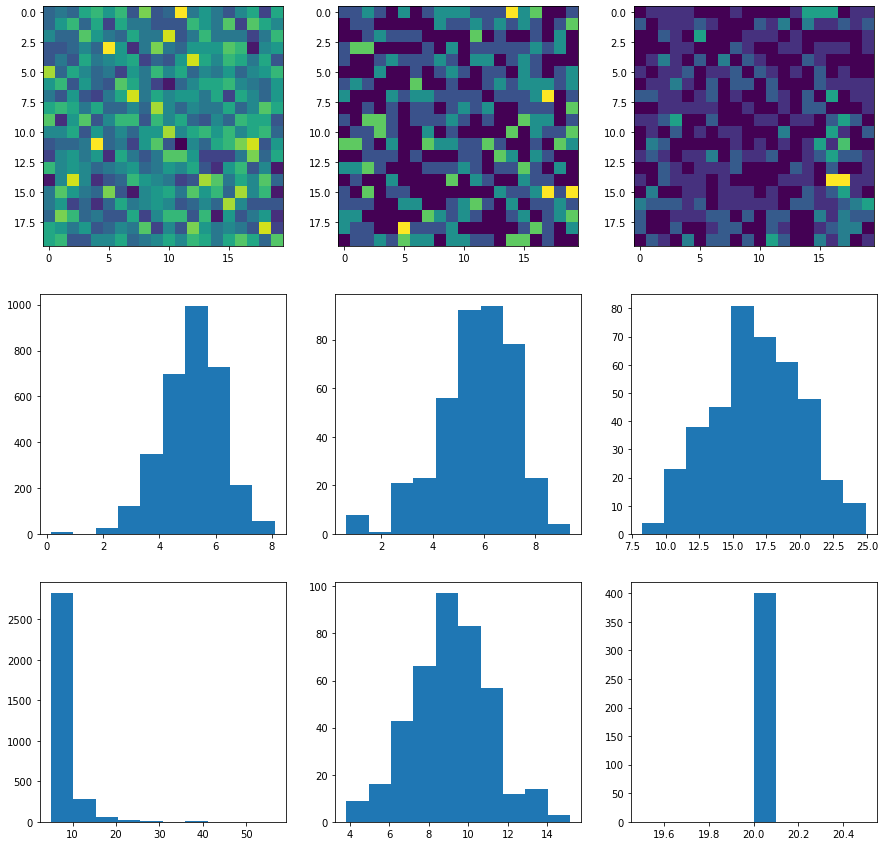

In [132]:
resultado = ab.return_agent_matrix()
value = ab.return_agent_value()
thresh = ab.return_agent_thresh()
infra_matrix = ab.location.get_infra_matrix()
fig, ax = plt.subplots(3,3, figsize = (15, 15))
ax[0,0].imshow(resultado[PopCasa])
ax[0,1].imshow(resultado[PopRua])
ax[0,2].imshow(resultado[PopSeg])
ax[1,0].hist(value[PopCasa])
ax[1,1].hist(value[PopRua])
ax[1,2].hist(value[PopSeg])
ax[2,0].hist(thresh[PopCasa])
ax[2,1].hist(thresh[PopRua])
ax[2,2].hist(thresh[PopSeg]);

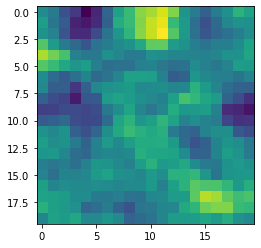

In [101]:
plt.imshow(infra_matrix);

/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_90586/2163917143.py:44: RuntimeWarning: divide by zero encountered in log
  ax[1,2].imshow(np.log(infra_matrix), cmap = 'gray')


(array([  5.,  13.,  28.,  63., 122., 101.,  38.,  15.,  10.,   5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

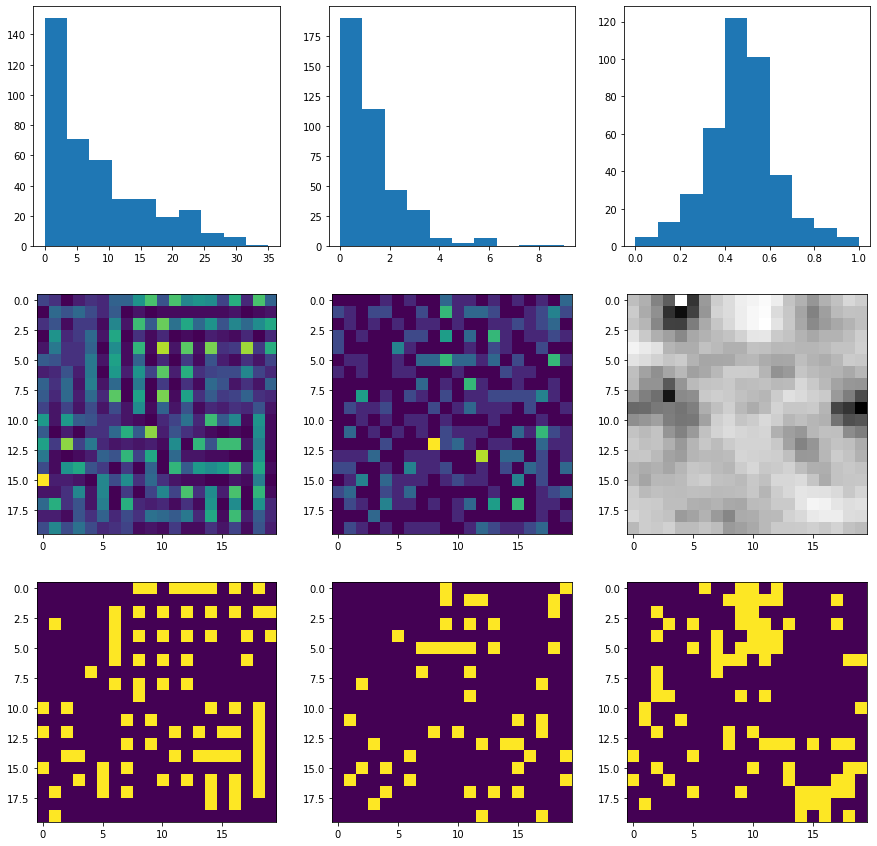

In [104]:
resultado = ab.return_agent_matrix()
thresh = ab.return_agent_thresh()
infra_matrix = ab.location.get_infra_matrix()
fig, ax = plt.subplots(3,3, figsize = (15, 15))

Q75 = np.quantile(resultado[PopRua].ravel(), 0.9)
def bla(num_hab):
    if num_hab >= Q75:
        return 1
    else:
        return 0
bla_vec = np.vectorize(bla)
arr_poprua = bla_vec(resultado[PopRua])

Q75 = np.quantile(resultado[PopCasa].ravel(), 0.8)
def bla(num_hab):
    if num_hab >= Q75:
        return 1
    else:
        return 0
bla_vec = np.vectorize(bla)
arr_popcasa = bla_vec(resultado[PopCasa])

Q75 = np.quantile(resultado[PopSeg].ravel(), 0.8)
def bla(num_hab):
    if num_hab >= Q75:
        return 1
    else:
        return 0
bla_vec = np.vectorize(bla)
arr_popseg = bla_vec(resultado[PopSeg])

Q75 = np.quantile(infra_matrix.ravel(), 0.8)
def bla(num_hab):
    if num_hab >= Q75:
        return 1
    else:
        return 0
bla_vec = np.vectorize(bla)
arr_infra = bla_vec(infra_matrix)

ax[1,0].imshow(resultado[PopCasa])
ax[1,1].imshow(resultado[PopRua])
ax[1,2].imshow(np.log(infra_matrix), cmap = 'gray')
ax[2,0].imshow(arr_popcasa)
ax[2,1].imshow(arr_poprua)
ax[2,2].imshow(arr_popseg)
ax[0,0].hist(resultado[PopCasa].ravel())
ax[0,1].hist(resultado[PopRua].ravel())
ax[0,2].hist(infra_matrix.ravel())

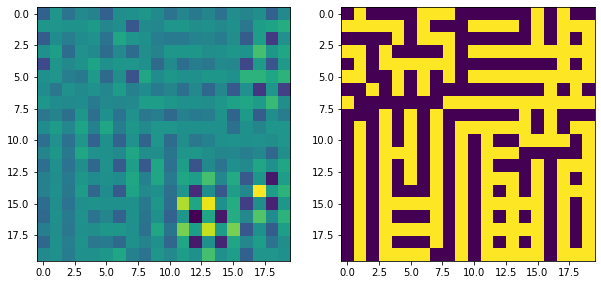

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
arr1 = resultado[PopRua]/np.max(resultado[PopRua]) - resultado[PopCasa]/np.max(resultado[PopCasa])
Q75 = np.quantile(arr1.ravel(), 0.5)
def bla(num_hab):
    if num_hab >= Q75:
        return 1
    else:
        return 0
bla_vec = np.vectorize(bla)
arr = bla_vec(arr1)
ax[0].imshow(arr1)
ax[1].imshow(arr)

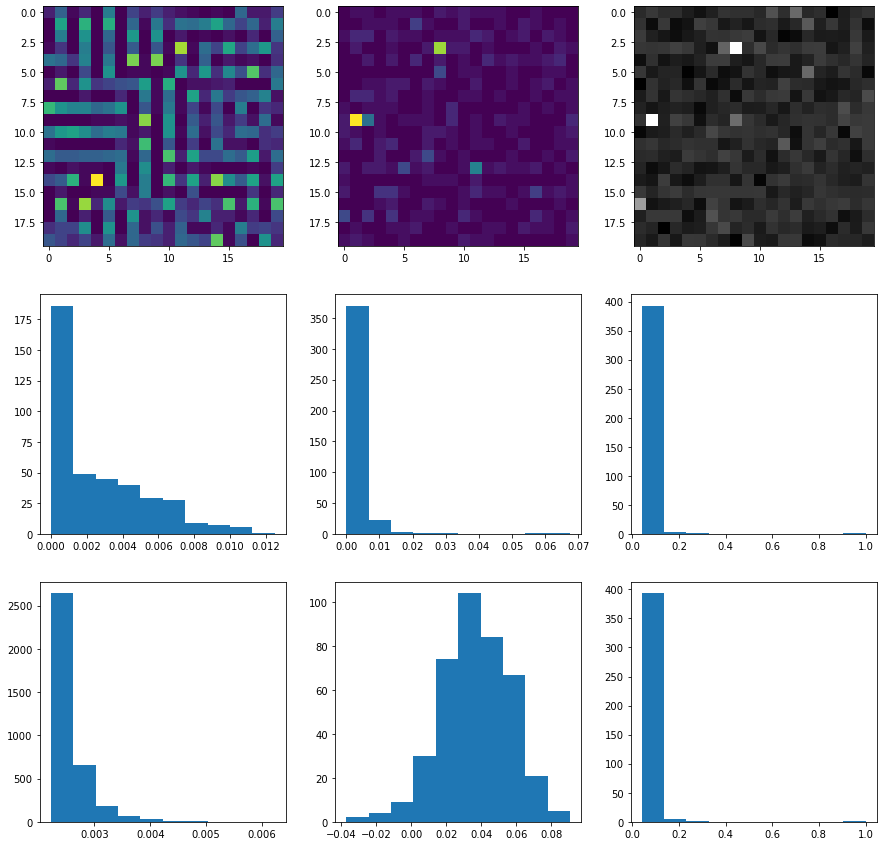

In [448]:
resultado = ab.return_agent_matrix()
thresh = ab.return_agent_thresh()
infra_matrix = ab.location.get_infra_matrix()
fig, ax = plt.subplots(3,3, figsize = (15, 15))
ax[0,0].imshow(resultado[PopCasa])
ax[0,1].imshow(resultado[PopRua])
ax[0,2].imshow(np.log(infra_matrix), cmap = 'gray')
ax[1,0].hist(resultado[PopCasa].ravel()/np.sum(resultado[PopCasa].ravel()))
ax[1,1].hist(resultado[PopRua].ravel()/np.sum(resultado[PopRua].ravel()))
ax[1,2].hist(infra_matrix.ravel())
ax[2,0].hist(thresh[PopCasa]/np.sum(resultado[PopCasa].ravel()))
ax[2,1].hist(thresh[PopRua]/np.sum(resultado[PopRua].ravel()))
ax[2,2].hist(infra_matrix.ravel());